In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load the data

In [ ]:
train_image_dir = '../input/UBC-OCEAN/train_images'
test_image_dir = '../input/UBC-OCEAN/test_images'

In [ ]:
train_data = pd.read_csv('../input/UBC-OCEAN/train.csv')

In [ ]:
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']
train_data = train_data[train_data['label'].isin(labels)]

In [ ]:
train_data['full_path'] = train_data['image_id'].apply(lambda x: os.path.join(train_image_dir, str(x) + '.png'))
train_data

,image_id,label,image_width,image_height,is_tma,full_path
0,4,HGSC,23785,20008,False,../input/UBC-OCEAN/train_images/4.png
1,66,LGSC,48871,48195,False,../input/UBC-OCEAN/train_images/66.png
2,91,HGSC,3388,3388,True,../input/UBC-OCEAN/train_images/91.png
3,281,LGSC,42309,15545,False,../input/UBC-OCEAN/train_images/281.png
4,286,EC,37204,30020,False,../input/UBC-OCEAN/train_images/286.png
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,../input/UBC-OCEAN/train_images/65022.png
534,65094,MC,55042,45080,False,../input/UBC-OCEAN/train_images/65094.png
535,65300,HGSC,75860,27503,False,../input/UBC-OCEAN/train_images/65300.png
536,65371,HGSC,42551,41800,False,../input/UBC-OCEAN/train_images/65371.png


Use all thumbnails images and the images missing in thumbnail folder but shown in train_images as training set.

In [ ]:
thumbnails_folder_path = '../input/UBC-OCEAN/train_thumbnails'

train_files = [filename.split('.')[0] for filename in os.listdir(train_image_dir)]
thumbnails_files = [filename.replace('_thumbnail', '').split('.')[0] for filename in os.listdir(thumbnails_folder_path)]

In [ ]:
train_set = set(train_files)
thumbnails_set = set(thumbnails_files)

missing_image_ids = train_set - thumbnails_set
missing_image_ids_list = list(missing_image_ids)

print(f"Number of missing images: {len(missing_image_ids_list)}")
print("Image IDs in train_files but not in thumbnails_files:")
print(missing_image_ids_list)

Number of missing images: 25
Image IDs in train_files but not in thumbnails_files:
['57696', '91', '29084', '50932', '47035', '44603', '4134', '36302', '8280', '13568', '17637', '42857', '53655', '40864', '35565', '36583', '48734', '21020', '41368', '61797', '9200', '31594', '37385', '41586', '36783']


In [ ]:
missing_image_ids_list = [int(image_id) for image_id in missing_image_ids_list]
filtered_train_data = train_data[train_data['image_id'].isin(missing_image_ids_list)]

filtered_train_data

,image_id,label,image_width,image_height,is_tma,full_path
2,91,HGSC,3388,3388,True,../input/UBC-OCEAN/train_images/91.png
37,4134,MC,2964,2964,True,../input/UBC-OCEAN/train_images/4134.png
76,8280,HGSC,2964,2964,True,../input/UBC-OCEAN/train_images/8280.png
83,9200,MC,3388,3388,True,../input/UBC-OCEAN/train_images/9200.png
112,13568,LGSC,2964,2964,True,../input/UBC-OCEAN/train_images/13568.png
149,17637,HGSC,2964,2964,True,../input/UBC-OCEAN/train_images/17637.png
176,21020,MC,3388,3388,True,../input/UBC-OCEAN/train_images/21020.png
236,29084,LGSC,3388,3388,True,../input/UBC-OCEAN/train_images/29084.png
263,31594,EC,3388,3388,True,../input/UBC-OCEAN/train_images/31594.png
288,35565,MC,2964,2964,True,../input/UBC-OCEAN/train_images/35565.png


In [ ]:
# creating full path column for each image in the train_data dataframe

train_data['full_path'] = ''
for index, row in train_data.iterrows():
    image_id = row['image_id']
    if image_id in missing_image_ids_list:
        train_data.at[index, 'full_path'] = os.path.join(train_image_dir, str(image_id) + '.png')
    else:
        train_data.at[index, 'full_path'] = os.path.join(thumbnails_folder_path, str(image_id) + '_thumbnail.png')

train_data

,image_id,label,image_width,image_height,is_tma,full_path
0,4,HGSC,23785,20008,False,../input/UBC-OCEAN/train_thumbnails/4_thumbnai...
1,66,LGSC,48871,48195,False,../input/UBC-OCEAN/train_thumbnails/66_thumbna...
2,91,HGSC,3388,3388,True,../input/UBC-OCEAN/train_images/91.png
3,281,LGSC,42309,15545,False,../input/UBC-OCEAN/train_thumbnails/281_thumbn...
4,286,EC,37204,30020,False,../input/UBC-OCEAN/train_thumbnails/286_thumbn...
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,../input/UBC-OCEAN/train_thumbnails/65022_thum...
534,65094,MC,55042,45080,False,../input/UBC-OCEAN/train_thumbnails/65094_thum...
535,65300,HGSC,75860,27503,False,../input/UBC-OCEAN/train_thumbnails/65300_thum...
536,65371,HGSC,42551,41800,False,../input/UBC-OCEAN/train_thumbnails/65371_thum...


In [ ]:
label_counts = train_data['label'].value_counts()
label_counts

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

# 2. Data pre-processing

In [ ]:
# Convert text to numeric
label_mapping = {'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}
train_data['label'] = train_data['label'].map(label_mapping)
train_data

,image_id,label,image_width,image_height,is_tma,full_path
0,4,2,23785,20008,False,../input/UBC-OCEAN/train_thumbnails/4_thumbnai...
1,66,3,48871,48195,False,../input/UBC-OCEAN/train_thumbnails/66_thumbna...
2,91,2,3388,3388,True,../input/UBC-OCEAN/train_images/91.png
3,281,3,42309,15545,False,../input/UBC-OCEAN/train_thumbnails/281_thumbn...
4,286,1,37204,30020,False,../input/UBC-OCEAN/train_thumbnails/286_thumbn...
...,...,...,...,...,...,...
533,65022,3,53355,46675,False,../input/UBC-OCEAN/train_thumbnails/65022_thum...
534,65094,4,55042,45080,False,../input/UBC-OCEAN/train_thumbnails/65094_thum...
535,65300,2,75860,27503,False,../input/UBC-OCEAN/train_thumbnails/65300_thum...
536,65371,2,42551,41800,False,../input/UBC-OCEAN/train_thumbnails/65371_thum...


In [ ]:
label_counts = train_data['label'].value_counts()
label_counts

label
2    222
1    124
0     99
3     47
4     46
Name: count, dtype: int64

## Data augmentation

In [ ]:
# Target each class has 300 samples
target_samples = 300

# Resample each class to have the target number of samples
resampled_data = []
for label in train_data['label'].unique():
    class_data = train_data[train_data['label'] == label]
    resampled_class = resample(class_data, replace=True, n_samples=target_samples, random_state=42)
    resampled_data.append(resampled_class)

balanced_train_data = pd.concat(resampled_data)

# Resize images to 600 * 600
image_size = (600, 600)

x_balanced = np.empty(shape=(len(balanced_train_data), *image_size, 3), dtype=np.uint8)
y_balanced = np.empty(shape=len(balanced_train_data), dtype=np.uint8)

for index, full_path in enumerate(balanced_train_data['full_path']):
    image_array = Image.open(full_path).resize(image_size).convert('RGB')
    x_balanced[index] = np.array(image_array)
    y_balanced[index] = balanced_train_data.iloc[index]['label']

print(x_balanced.shape)
print(y_balanced.shape)

(1500, 600, 600, 3)
(1500,)


In [ ]:
# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_balanced)

# 3. Modeling - VGG19

In [ ]:
# Get X
X = x_balanced

# Create one-hot encoding for y
y_one_hot = to_categorical(y_balanced, num_classes=5)

In [ ]:
# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1200, 600, 600, 3), (1200, 5), (300, 600, 600, 3), (300, 5))

In [ ]:
# Create the model based on VGG19
base_model = VGG19(
    include_top=False,
    input_shape=(600, 600, 3),
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

# Define the sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation='softmax')
])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Compile the model with class weights
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 18, 18, 512)       20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 20057541 (76.51 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 20024384 (76.39 MB)
__________

In [ ]:
# Train
EPOCHS = 150
batch_size = 32

history = model.fit(
          X_train,
          y_train,
          validation_data=(X_val, y_val),
          epochs=EPOCHS,
          batch_size=batch_size
         )

Epoch 1/150
38/38 [==============================] - 55s 946ms/step - loss: 8.2433 - accuracy: 0.2767 - precision: 0.2759 - recall: 0.2683 - val_loss: 5.5121 - val_accuracy: 0.3367 - val_precision: 0.3393 - val_recall: 0.3167
Epoch 2/150
38/38 [==============================] - 23s 596ms/step - loss: 2.6318 - accuracy: 0.3925 - precision: 0.4125 - recall: 0.3533 - val_loss: 2.8558 - val_accuracy: 0.4500 - val_precision: 0.5385 - val_recall: 0.3500
Epoch 3/150
38/38 [==============================] - 23s 598ms/step - loss: 1.3757 - accuracy: 0.4675 - precision: 0.5712 - recall: 0.3042 - val_loss: 2.4639 - val_accuracy: 0.4867 - val_precision: 0.5299 - val_recall: 0.2367
Epoch 4/150
38/38 [==============================] - 23s 601ms/step - loss: 1.1759 - accuracy: 0.5233 - precision: 0.6667 - recall: 0.3367 - val_loss: 2.2471 - val_accuracy: 0.5300 - val_precision: 0.6797 - val_recall: 0.3467
Epoch 5/150
38/38 [==============================] - 23s 599ms/step - loss: 1.0315 - accuracy: 0

# 4. Evaluation

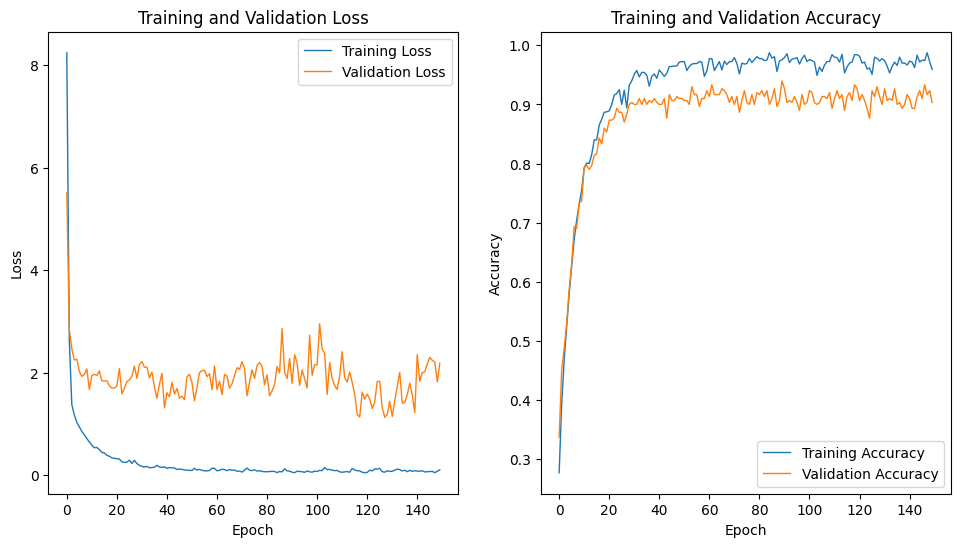

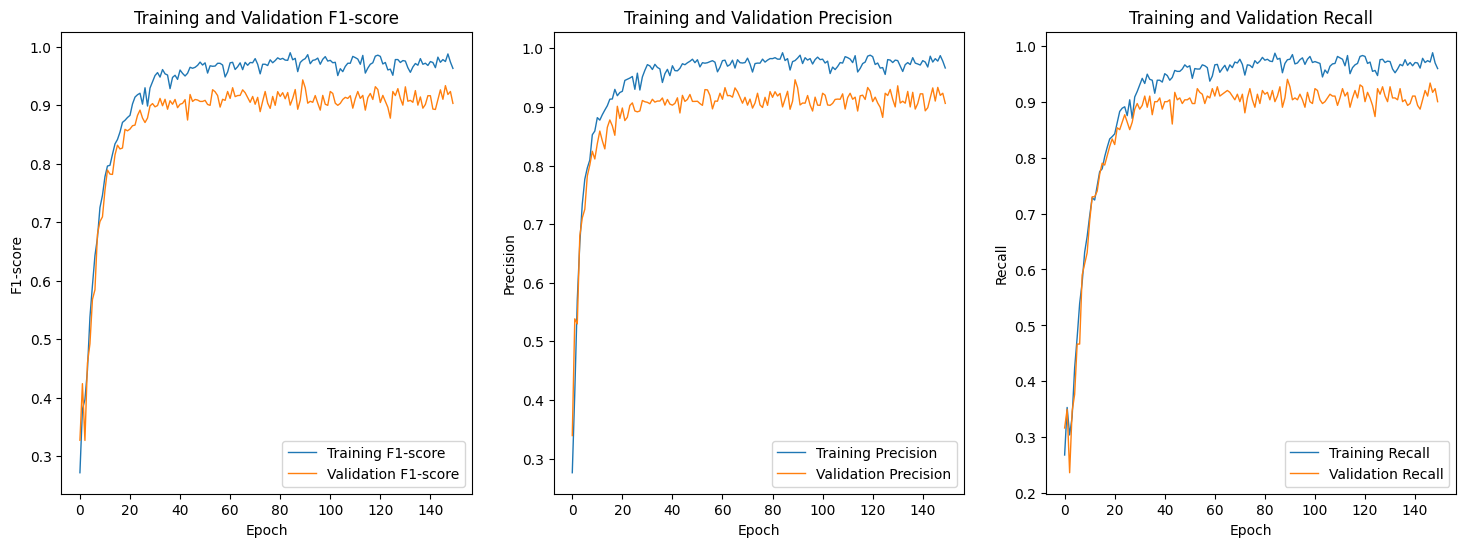

In [ ]:
# Access training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_precision = history.history['precision']
validation_precision = history.history['val_precision']
training_recall = history.history['recall']
validation_recall = history.history['val_recall']


# Figure 1: loss and accuracy
plt.figure(figsize=(18, 6))

# Plot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(training_loss, label='Training Loss', linewidth=1)
plt.plot(validation_loss, label='Validation Loss', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(training_accuracy, label='Training Accuracy', linewidth=1)
plt.plot(validation_accuracy, label='Validation Accuracy', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


# Figure 2: F1-score, Precision, and Recall
plt.figure(figsize=(18, 6))

# # Plot 3: F1-score
plt.subplot(1, 3, 1)
train_f1_score = [2 * (p * r) / (p + r) for p, r in zip(training_precision, training_recall)]
val_f1_score = [2 * (p * r) / (p + r) for p, r in zip(validation_precision, validation_recall)]

plt.plot(train_f1_score, label='Training F1-score', linewidth=1)
plt.plot(val_f1_score, label='Validation F1-score', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and Validation F1-score')

# Plot 4: Precision
plt.subplot(1, 3, 2)
plt.plot(training_precision, label='Training Precision', linewidth=1)
plt.plot(validation_precision, label='Validation Precision', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Training and Validation Precision')

# Plot 5: Recall
plt.subplot(1, 3, 3)
plt.plot(training_recall, label='Training Recall', linewidth=1)
plt.plot(validation_recall, label='Validation Recall', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')

# Show the plots
plt.show()

In [ ]:
# Classification report for validation set
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1)

class_report = classification_report(y_true, y_pred)

print("\n Training Classification Report:\n", class_report)

38/38 [==============================] - 18s 474ms/step

 Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       0.99      0.99      0.99       251
           2       0.99      0.99      0.99       244
           3       1.00      1.00      1.00       235
           4       1.00      1.00      1.00       236

    accuracy                           0.99      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       0.99      0.99      0.99      1200



In [ ]:
# Classification report for validation set
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)

class_report = classification_report(y_true, y_pred)

print("\n Validation Classification Report:\n", class_report)

10/10 [==============================] - 4s 473ms/step

 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        66
           1       0.76      0.92      0.83        49
           2       0.84      0.88      0.86        56
           3       0.98      0.97      0.98        65
           4       0.98      0.94      0.96        64

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



# 5. Predict on test data

Load test data

In [ ]:
test_data = pd.read_csv('../input/UBC-OCEAN/test.csv')
test_data

,image_id,image_width,image_height
0,41,28469,16987


In [ ]:
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'
test_data['full_path'] = test_data['image_id'].apply(lambda x: os.path.join(test_thumbnails_folder_path, f"{x}_thumbnail.png"))

In [ ]:
x_test = np.empty(shape=(len(test_data), 600, 600, 3), dtype=np.uint8)

for index, full_path in enumerate(test_data['full_path']):
    image_array = Image.open(full_path).resize((600, 600)).convert('RGB')
    x_test[index] = image_array

print(x_test.shape)

(1, 600, 600, 3)


Predict test data

In [ ]:
predictions = model.predict(x_test)
predictions

1/1 [==============================] - 1s 740ms/step


array([[0., 0., 0., 1., 0.]], dtype=float32)

Create submission file

In [ ]:
test_data['label'] = predictions.argmax(axis=1)  # Assuming one-hot encoding, get the index of the max value
submission_df = test_data[['image_id', 'label']]

reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Map numerical labels to actual labels
submission_df.loc[:, 'label'] = submission_df['label'].map(reverse_label_mapping)

submission_df

,image_id,label
0,41,LGSC


In [ ]:
# Save to CSV
submission_df.to_csv('vgg_submission.csv', index=False)

Save model weights

In [ ]:
# Save the entire model (architecture and weights)
model.save('full_vgg_model.h5')

# To later load the entire model
loaded_model = tf.keras.models.load_model('full_vgg_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
